# Code for Hierarchical Clustering to obtain labels (suitability category)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [2]:
# Set seed for whole notebook
import random
random.seed(10)

In [3]:
#Loading locational dataset
df = pd.read_csv('final-scaled-df.csv', index_col='FIPS')
df.head(20)

,Biomass,Power,Water Availability,Log_Bio,Log_Water,Log_Power,Income,DSCI,PQ1,PQ2,PQ3,PQ4,TQ1,TQ2,TQ3,TQ4,Forest,Agriculture,Watershed
FIPS,,,,,,,,,,,,,,,,,,,
51001,0.185901,0.601097,0.020793,0.606148,0.417871,0.931630,0.075854,0.148920,0.319901,0.435870,0.410805,0.412876,0.398849,0.223717,0.178736,0.296552,0.064338,0.289624,1
51003,0.354645,0.494455,0.157825,0.754033,0.718885,0.000000,0.108095,0.182011,0.281478,0.361577,0.330150,0.398268,0.652957,0.669414,0.672845,0.580575,0.679813,0.081093,1
51005,0.654945,0.494455,0.083128,0.898739,0.622105,0.000000,0.187226,0.147870,0.208440,0.382735,0.309672,0.361536,0.590581,0.651482,0.660489,0.531379,0.897165,0.020858,1
51007,0.648261,0.515919,0.018988,0.896297,0.404927,0.861198,0.157467,0.144258,0.319836,0.347694,0.488828,0.370654,0.753323,0.808243,0.809483,0.716207,0.651586,0.155517,1
51009,0.236541,0.502679,0.145085,0.660592,0.706138,0.819049,0.184217,0.145333,0.205452,0.416978,0.325681,0.367647,0.499006,0.525380,0.539368,0.463678,0.770831,0.072140,1
51011,0.099752,0.516467,0.082587,0.471095,0.621123,0.862305,0.140248,0.158561,0.278259,0.427413,0.398133,0.403431,0.427002,0.337238,0.280747,0.347356,0.662506,0.159655,1
51013,0.101754,0.494455,0.023823,0.475250,0.437398,0.000000,0.142115,0.105105,0.229655,0.409510,0.284420,0.314118,0.436525,0.430658,0.397845,0.371264,0.089268,0.001349,1
51015,0.421279,0.494455,0.126500,0.794329,0.685401,0.000000,0.197927,0.147820,0.225123,0.379990,0.321457,0.383072,0.615071,0.686479,0.682759,0.561379,0.582228,0.137797,1
51017,0.165266,0.000000,0.098558,0.579941,0.647728,0.000000,0.382682,0.130588,0.262562,0.372108,0.370891,0.394608,0.681005,0.768185,0.779741,0.641724,0.899831,0.020852,1


In [4]:
TEST_RATIO = 0.2
BATCH_SIZE = 16

size_all = len(df)

# training/val/test dataset
size_train = size_all - 6
size_val = int(size_train * TEST_RATIO)
size_train_sub = size_train - size_val

# split data into train and test
# Test = 6 counties of interst: Accomack, Fauquier, Greensville, Hanover, Rockingham, Wise
dataset_val = df.loc[[51001, 51061, 51081, 51085, 51165, 51195]]

# Train = all except 6 counties of interest
dataset_train = df.drop([51001, 51061, 51081, 51085, 51165, 51195])


# Reforestation Clustering

In [5]:
cols = ['Income', 'DSCI', 'PQ1', 'PQ2', 'PQ3', 'PQ4', 'TQ1', 'TQ2', 'TQ3', 'TQ4', 'Forest', 
        'Agriculture', 'Biomass', 'Power', 'Water Availability', 'Watershed',
       'Log_Bio','Log_Water','Log_Power']


# Using the elbow method to determine the k value to be applied
k_rng = range(1, 10)
sse = []
for k in k_rng:
    km = KMeans(n_clusters=k, n_init=10)
    km.fit(df[['PQ1', 'PQ2', 'PQ3', 'PQ4', 'TQ1', 'TQ2', 'TQ3', 'TQ4', 'Forest','Log_Water']])
    sse.append(km.inertia_)

C:\Users\daven\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\daven\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\daven\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\daven\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

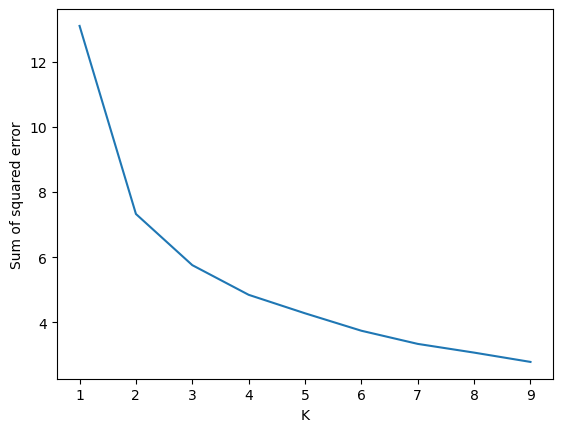

In [6]:
# Plot to obtain elbow
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng, sse)

In [7]:
# create clusters using k value = 4
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')

In [8]:
# Determining mean cluster characterisitics REFORESTATION
y_hc = hc.fit_predict(dataset_train[['PQ1', 'PQ2', 'PQ3', 'PQ4', 'TQ1', 'TQ2', 'TQ3', 'TQ4', 'Forest','Water Availability', 'Log_Water']])
dataset_train['Reforest'] = y_hc
dataset_train.sort_values("Reforest", inplace = True, ascending=True)

#average input vars by cluster
df_rfcluster = dataset_train.groupby('Reforest').mean()


# Determining mean cluster characterisitics ENHANCED WEATHERING
y_hc = hc.fit_predict(dataset_train[['PQ1', 'PQ2', 'PQ3', 'PQ4', 'TQ1', 'TQ2', 'TQ3', 'TQ4', 'Income', 'Power', 'Log_Power', 'Agriculture']])
dataset_train['EW'] = y_hc
dataset_train.sort_values("EW", inplace = True, ascending=True)

#average input vars by cluster
df_ewcluster = dataset_train.groupby('EW').mean()


# Determining mean cluster characterisitics BIOCHAR
y_hc = hc.fit_predict(dataset_train[['PQ1', 'PQ2', 'PQ3', 'PQ4', 'TQ1', 'TQ2', 'TQ3', 'TQ4', 'Income', 'Biomass', 'Log_Bio','Agriculture']])
dataset_train['Biochar'] = y_hc
dataset_train.sort_values("Biochar", inplace = True, ascending=True)

#average input vars by cluster
df_biocluster = dataset_train.groupby('Biochar').mean()

C:\Users\daven\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
C:\Users\daven\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
C:\Users\daven\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


<Axes: ylabel='Biochar'>

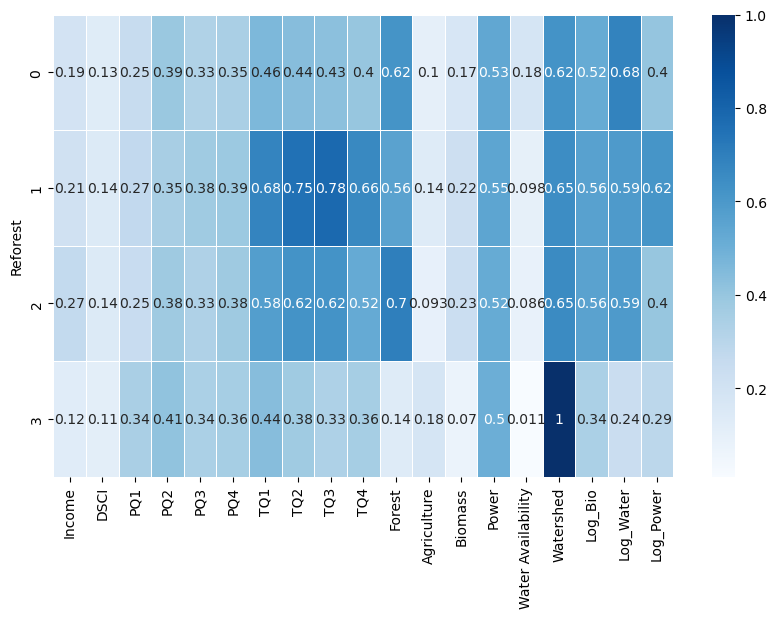

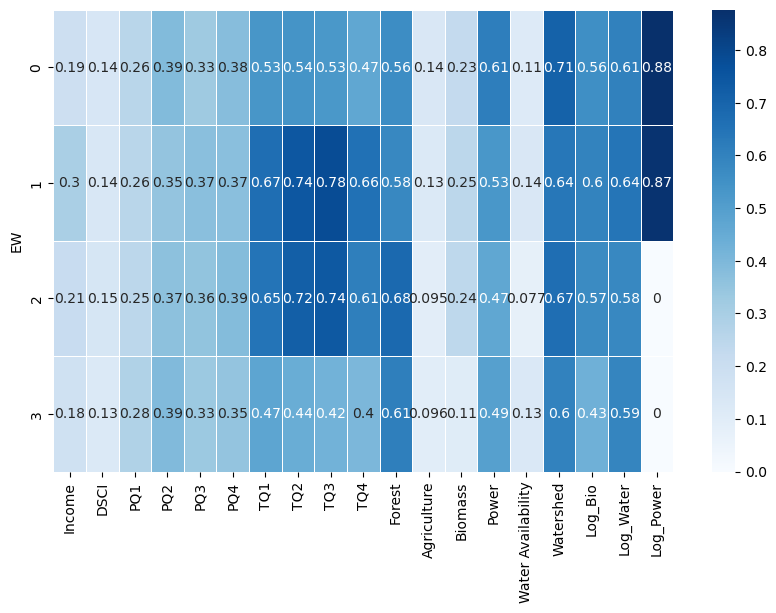

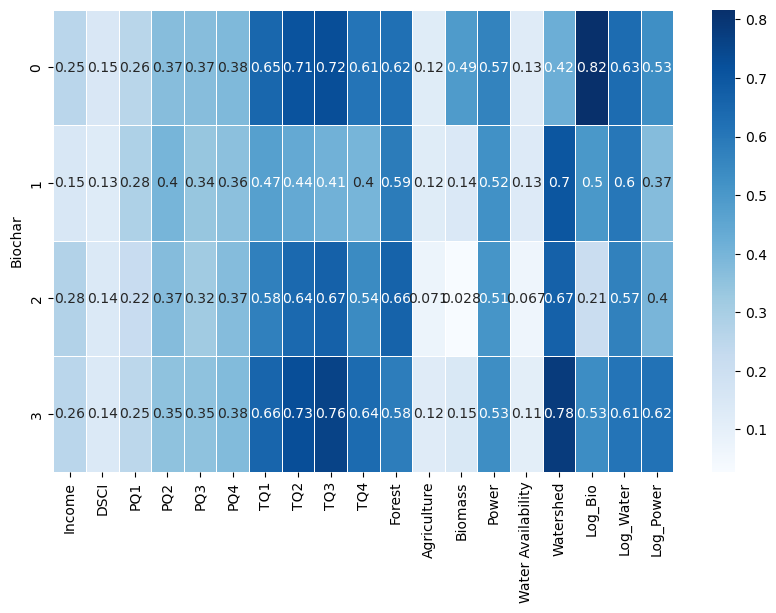

In [9]:
#Heatmap of cluster characteristics reforestation
plt.figure(figsize=(10,6))
sns.heatmap(df_rfcluster[cols], annot=True, cmap="Blues", linewidths=.5)

plt.figure(figsize=(10,6))
sns.heatmap(df_ewcluster[cols], annot=True, cmap="Blues", linewidths=.5)

plt.figure(figsize=(10,6))
sns.heatmap(df_biocluster[cols], annot=True, cmap="Blues", linewidths=.5)

In [10]:
# see how clusters are distributed
dataset_train['Reforest'].value_counts()

Reforest
1    31
2    26
0    24
3     3
Name: count, dtype: int64

In [11]:
dataset_train['EW'].value_counts()

EW
0    24
1    22
3    20
2    18
Name: count, dtype: int64

In [12]:
dataset_train['Biochar'].value_counts()

Biochar
1    30
3    23
0    19
2    12
Name: count, dtype: int64

In [13]:
# Look at counties in smallest cluster
dataset_train[dataset_train['Reforest'] == 3]

,Biomass,Power,Water Availability,Log_Bio,Log_Water,Log_Power,Income,DSCI,PQ1,PQ2,...,TQ1,TQ2,TQ3,TQ4,Forest,Agriculture,Watershed,Reforest,EW,Biochar
FIPS,,,,,,,,,,,,,,,,,,,,,
51115,0.006277,0.494455,0.000000,0.076886,0.000000,0.00000,0.131867,0.118457,0.362594,0.415861,...,0.411094,0.293565,0.254598,0.315172,0.224077,0.094584,1,3,3,1
51013,0.101754,0.494455,0.023823,0.475250,0.437398,0.00000,0.142115,0.105105,0.229655,0.409510,...,0.436525,0.430658,0.397845,0.371264,0.089268,0.001349,1,3,3,1
51131,0.100844,0.519490,0.007939,0.473371,0.285964,0.86796,0.099351,0.117189,0.439573,0.415893,...,0.467713,0.404628,0.346264,0.386092,0.098323,0.449594,1,3,0,1


# Label the clusters as suitability levels

In [14]:
# Maybe redo if we can get more data and redo clusters

# 0 = highly suitable (most forest land, mild summer temps, warm winter temps, faitly high precip, high income, avg drought)
# 2 = suitable (high income, high summer and wimter temps, high rain, good about of forest)
# 1 = possible (lots of forest land, slightly cold, lots of rain, not the best income)
# 3 = unsuitable (too cold, too little forest land, low income)

# Supervised ML for suitability prediction

# Random Forest

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [16]:
# Reading data
# df = pd.read_csv("Labelled Normalised DACCS data.csv")

In [24]:
# creating input identity
sub_df = dataset_train[cols]
X = sub_df
y = dataset_train[['Reforest','EW','Biochar']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

In [25]:
y_train_rf = y_train[['Reforest']]
y_train_ew = y_train[['EW']]
y_train_bio = y_train[['Biochar']]

y_test_rf = y_test[['Reforest']]
y_test_ew = y_test[['EW']]
y_test_bio = y_test[['Biochar']]

In [29]:
# creating Model (with 100 trees)
rf_rf = RandomForestClassifier(n_estimators=100)
rf_ew = RandomForestClassifier(n_estimators=100)
rf_bio = RandomForestClassifier(n_estimators=100)

In [30]:
# Fitting training data
rf_rf.fit(X_train, y_train_rf)
rf_ew.fit(X_train, y_train_ew)
rf_bio.fit(X_train, y_train_bio)

C:\Users\daven\AppData\Local\Temp\ipykernel_1028\1459246705.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_rf.fit(X_train, y_train_rf)
C:\Users\daven\AppData\Local\Temp\ipykernel_1028\1459246705.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_ew.fit(X_train, y_train_ew)
C:\Users\daven\AppData\Local\Temp\ipykernel_1028\1459246705.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_bio.fit(X_train, y_train_bio)


RandomForestClassifier()

In [21]:
# see which counties are in test
y_test_rf.index

Index([51083, 51193, 51155, 51197, 51119, 51099, 51107, 51011, 51041, 51139,
       51017, 51057, 51105, 51179, 51157, 51177, 51089],
      dtype='int64', name='FIPS')

In [28]:
#make predictions
y_pred_rf = rf_rf.predict(X_test)
y_pred_ew = rf_ew.predict(X_test)
y_pred_bio = rf_bio.predict(X_test)

#for pred_label, true_label, index in zip(y_pred_ew, y_test_ew, y_test_ew.index):
 #   print(pred_label, true_label, index)

In [33]:
X_test

,Income,DSCI,PQ1,PQ2,PQ3,PQ4,TQ1,TQ2,TQ3,TQ4,Forest,Agriculture,Biomass,Power,Water Availability,Watershed,Log_Bio,Log_Water,Log_Power
FIPS,,,,,,,,,,,,,,,,,,,
51083,0.180620,0.117508,0.309261,0.382448,0.486501,0.370359,0.751020,0.832104,0.847557,0.737011,0.636051,0.106836,0.420004,0.735490,0.293669,0,0.793617,0.813186,0.967457
51193,0.258949,0.131812,0.228013,0.338631,0.349740,0.407190,0.622397,0.713955,0.782040,0.648621,0.437404,0.266253,0.115573,0.531466,0.238819,1,0.502151,0.781747,0.885136
51155,0.269759,0.142260,0.189557,0.368374,0.304408,0.344575,0.574987,0.647433,0.672701,0.527816,0.570032,0.082399,0.008989,0.661765,0.098290,0,0.103836,0.647318,0.951417
51197,0.146351,0.138240,0.242365,0.352577,0.328375,0.316046,0.490215,0.425307,0.388793,0.394943,0.538871,0.123598,0.033949,0.494455,0.132177,0,0.268422,0.692039,0.000000
51119,0.288691,0.145223,0.257406,0.366778,0.358004,0.384935,0.685191,0.761967,0.770690,0.640690,0.492955,0.213187,0.042607,0.546687,0.008078,1,0.306788,0.288215,0.900269
51099,0.304252,0.125694,0.179672,0.346322,0.320049,0.340196,0.629409,0.725958,0.781178,0.618736,0.546012,0.148928,0.073209,0.538957,0.160332,1,0.408061,0.721273,0.893234
51107,0.176528,0.129553,0.262200,0.422371,0.304163,0.345719,0.243119,0.193782,0.158764,0.189310,0.359856,0.153795,0.261578,0.494455,1.000000,1,0.683603,1.000000,0.000000
51011,0.140248,0.158561,0.278259,0.427413,0.398133,0.403431,0.427002,0.337238,0.280747,0.347356,0.662506,0.159655,0.099752,0.516467,0.082587,1,0.471095,0.621123,0.862305
51041,0.141137,0.113755,0.235895,0.398596,0.323049,0.352810,0.441758,0.422704,0.382615,0.374023,0.548453,0.034519,0.241023,0.544519,0.070362,1,0.664874,0.597087,0.898407


In [35]:
dataset_val = dataset_val[['Income','DSCI','PQ1','PQ2','PQ3','PQ4','TQ1','TQ2','TQ3','TQ4','Forest','Agriculture','Biomass','Power','Water Availability','Watershed','Log_Bio','Log_Water','Log_Power']]

In [39]:
dataset_val

,Income,DSCI,PQ1,PQ2,PQ3,PQ4,TQ1,TQ2,TQ3,TQ4,Forest,Agriculture,Biomass,Power,Water Availability,Watershed,Log_Bio,Log_Water,Log_Power
FIPS,,,,,,,,,,,,,,,,,,,
51001,0.075854,0.148920,0.319901,0.435870,0.410805,0.412876,0.398849,0.223717,0.178736,0.296552,0.064338,0.289624,0.185901,0.601097,0.020793,1,0.606148,0.417871,0.931630
51061,0.056851,0.167551,0.233793,0.342333,0.304255,0.396601,0.628571,0.683586,0.670833,0.564368,0.487013,0.183565,0.120249,0.517996,0.390361,1,0.510621,0.856517,0.865257
51081,0.182271,0.170831,0.257011,0.335918,0.321886,0.387484,0.670958,0.733478,0.734626,0.610575,0.516608,0.154259,1.000000,0.659539,0.016596,0,1.000000,0.385892,0.950829
51085,0.109010,0.120935,0.291921,0.348811,0.306122,0.323072,0.410152,0.300072,0.257615,0.310115,0.544643,0.175271,0.485122,0.532257,0.059144,1,0.827556,0.571115,0.886064
51165,0.340954,0.133257,0.247323,0.376384,0.347475,0.400065,0.641026,0.726103,0.734914,0.596897,0.587453,0.186935,0.244045,0.499932,0.080305,1,0.667719,0.616914,0.801193
51195,0.155507,0.156524,0.268670,0.338216,0.365901,0.380425,0.704343,0.766016,0.776580,0.659425,0.753340,0.011247,0.056099,0.567249,0.086864,0,0.356660,0.628714,0.914854


In [75]:
rf_vals = rf_rf.predict(dataset_val)

In [72]:
rf_dict = {0:'Suitable',
          1: 'Possible',
          2: 'Highly Suitable',
          3: 'Unsuitable'}

In [76]:
ew_vals = rf_ew.predict(dataset_val)

In [62]:
ew_dict = {0:'Highly Suitable',
          1: 'Suitable',
          2: 'Unsuitable',
          3: 'Possible'}

In [77]:
bio_vals = rf_bio.predict(dataset_val)

In [63]:
bio_dict = {0:'Highly Suitable',
          1: 'Possible',
          2: 'Unsuitable',
          3: 'Suitable'}

In [159]:
data = {'Reforestation' : rf_vals,
        'EW' : ew_vals,
        'Biochar' : bio_vals
}

df = pd.DataFrame(data)

In [133]:
df

,Reforestation,EW,Biochar
0,3,0,1
1,1,0,3
2,1,1,0
3,0,0,1
4,1,1,3
5,1,1,3


In [160]:
df.Reforestation = df.Reforestation.map(rf_dict)
df.EW = df.EW.map(ew_dict)
df.Biochar = df.Biochar.map(bio_dict)

In [135]:
df

,Reforestation,EW,Biochar
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN


In [161]:
index = ['51001','51061','51081','51085','51165','51195']

In [162]:
df.set_index(pd.Index(index), inplace=True)

In [138]:
df

,Reforestation,EW,Biochar
51001,Unsuitable,Highly Suitable,Possible
51061,Possible,Highly Suitable,Suitable
51081,Possible,Suitable,Highly Suitable
51085,Suitable,Highly Suitable,Possible
51165,Possible,Suitable,Suitable
51195,Possible,Suitable,Suitable


In [163]:
big_dict = {'Highly Suitable': 4,
           'Suitable': 3,
           'Possible': 2,
           'Unsuitable': 1}

In [164]:
df.Reforestation = df.Reforestation.map(big_dict)
df.EW = df.EW.map(big_dict)
df.Biochar = df.Biochar.map(big_dict)

In [141]:
df

,Reforestation,EW,Biochar
51001,1,4,2
51061,2,4,3
51081,2,3,4
51085,3,4,2
51165,2,3,3
51195,2,3,3


In [165]:
index_dict = {'51001': 'Accomack',
             '51061': 'Fauquier',
             '51081': 'Greensville',
             '51085': 'Hanover',
             '51165': 'Rockingham',
             '51195': 'Wise'}

In [166]:
df.index = df.index.map(index_dict)

In [167]:
df

,Reforestation,EW,Biochar
Accomack,1,4,2
Fauquier,2,4,3
Greensville,2,3,4
Hanover,3,4,2
Rockingham,2,3,3
Wise,2,3,3


In [168]:
custom_labels = ['Unsuitable','Possible','Suitable','Highly Suitable']
positions = 1,2,3,4

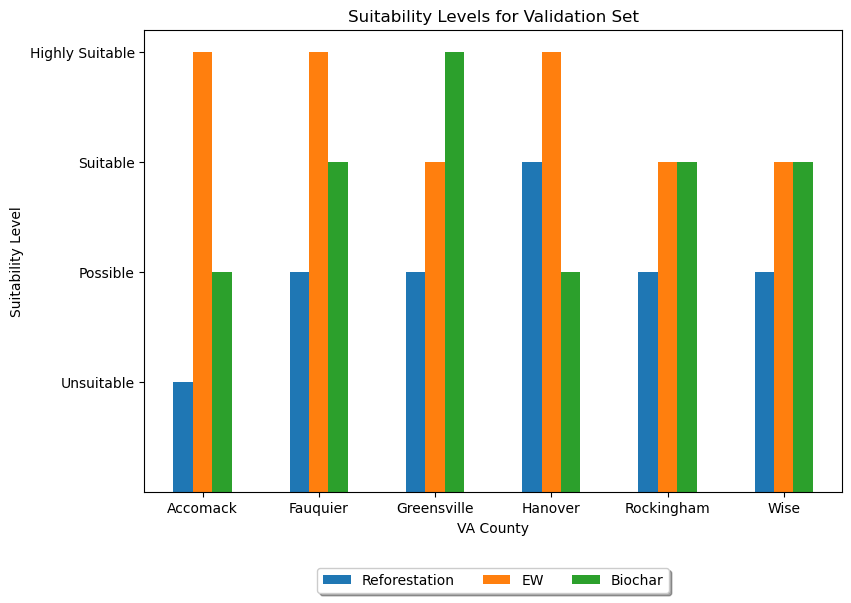

In [169]:
df.plot(kind='bar')
plt.xlabel('VA County')
plt.ylabel('Suitability Level')
plt.xticks(rotation=360)
plt.yticks(positions, custom_labels)
plt.title('Suitability Levels for Validation Set')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=4)

plt.show()

In [269]:
accuracy_dict = {'Accuracy' : [0.882,0.941,0.882,0.941,0.647,0.882,0.941,0.941,1.0,1.0,0.882,1.0,0.588,0.882,0.941,0.941,1.0,0.941,0.824,1.0,0.294,1.0,1.0,0.882],
        'GGR' : ['Reforestation','Reforestation','Reforestation','Reforestation','Reforestation','Reforestation','Reforestation','Reforestation',
                'EW','EW','EW','EW','EW','EW','EW','EW',
                'Biochar','Biochar','Biochar','Biochar','Biochar','Biochar','Biochar','Biochar'],
        'Model' : ['Random Forest','Logistic Regression','Decision Tree','KNN','Naive Bayes','Graident Boost','MLP','ANN',
                  'Random Forest','Logistic Regression','Decision Tree','KNN','Naive Bayes','Graident Boost','MLP','ANN',
                  'Random Forest','Logistic Regression','Decision Tree','KNN','Naive Bayes','Graident Boost','MLP','ANN']
}

accuracy = pd.DataFrame(accuracy_dict)

In [270]:
accuracy

,Accuracy,GGR,Model
0,0.882,Reforestation,Random Forest
1,0.941,Reforestation,Logistic Regression
2,0.882,Reforestation,Decision Tree
3,0.941,Reforestation,KNN
4,0.647,Reforestation,Naive Bayes
5,0.882,Reforestation,Graident Boost
6,0.941,Reforestation,MLP
7,0.941,Reforestation,ANN
8,1.000,EW,Random Forest
9,1.000,EW,Logistic Regression


In [237]:
import seaborn as sns

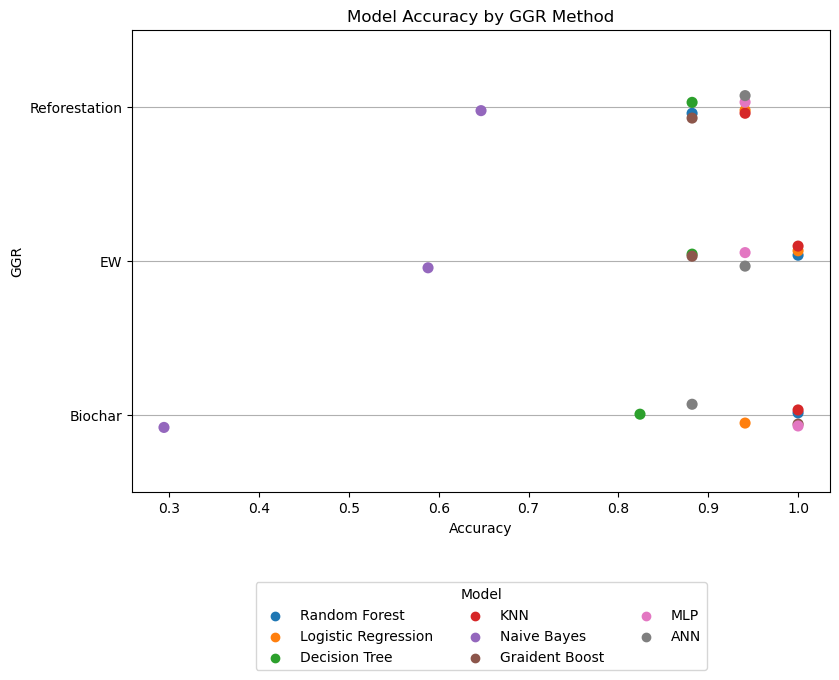

In [297]:
sns.stripplot(data=accuracy, x='Accuracy', y='GGR', hue='Model', dodge=False, jitter=True, size=8)
plt.xlabel('Accuracy')
plt.ylabel('GGR')
plt.title('Model Accuracy by GGR Method')
plt.legend(title='Model', loc='lower center', bbox_to_anchor=(0.5,-0.4), ncol=3)

plt.grid(True, axis='y')

plt.show()

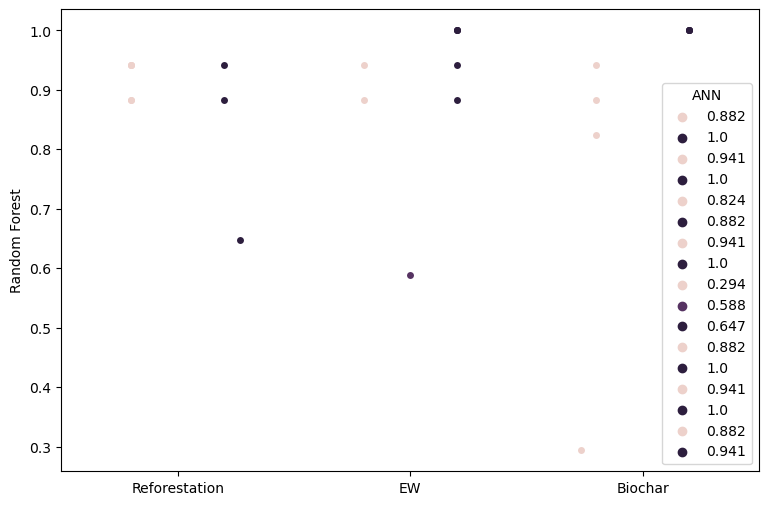

In [245]:
for column in accuracy.columns:
    sns.stripplot(data=accuracy,x=accuracy.index, y=accuracy[column], dodge=True, hue=accuracy[column])

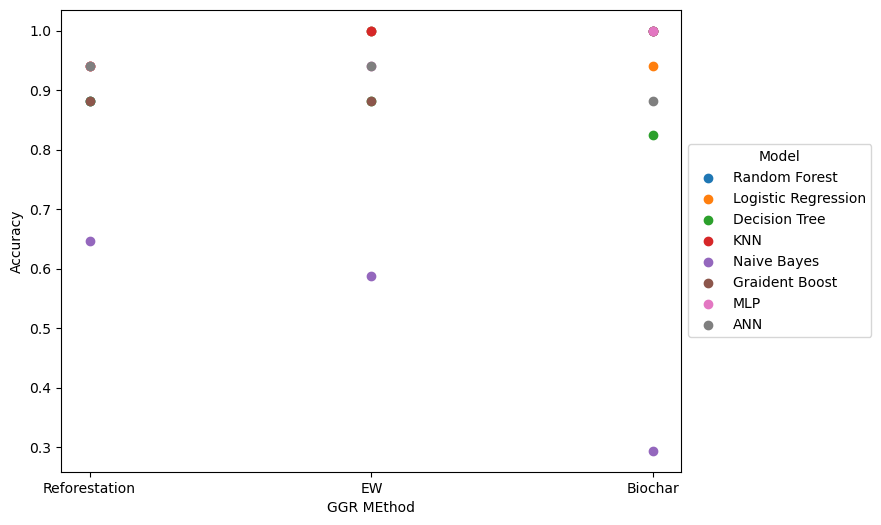

In [236]:
plt.figure(figsize=(8, 6))

for column in accuracy.columns:
    plt.scatter(accuracy.index, accuracy[column], label=column)

plt.xlabel('GGR MEthod')
plt.ylabel('Accuracy')
plt.xticks(accuracy.index)
plt.legend(title='Model', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [23]:
# To get model performance 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
cr1 = classification_report(y_test_rf, y_pred_rf)
cr2 = classification_report(y_test_ew, y_pred_ew)
cr3 = classification_report(y_test_bio, y_pred_bio)
print('Reforestation:\n' , cr1, '\n')
print('EW:\n' , cr2, '\n')
print('Biochar:\n' , cr3, '\n')

Reforestation:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.78      0.88      0.82         8
           2       0.67      0.50      0.57         4

    accuracy                           0.82        17
   macro avg       0.81      0.79      0.80        17
weighted avg       0.82      0.82      0.82        17
 

EW:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.67      0.86      0.75         7
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3

    accuracy                           0.53        17
   macro avg       0.32      0.36      0.34        17
weighted avg       0.45      0.53      0.49        17
 

Biochar:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0

C:\Users\daven\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\daven\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\daven\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\daven\anaconda3\lib\site-packages\sklearn\metr

In [24]:
print("Reforestation Accuracy:", accuracy_score(y_test_rf, y_pred_rf), '\n')
print("EW Accuracy:", accuracy_score(y_test_ew, y_pred_ew), '\n')
print("Biochar Accuracy:", accuracy_score(y_test_bio, y_pred_bio), '\n')

Reforestation Accuracy: 0.8235294117647058 

EW Accuracy: 0.5294117647058824 

Biochar Accuracy: 0.11764705882352941 



In [25]:
# Determining feature importance (Model Interpretation)
feature_imp_rf = pd.DataFrame(rf_rf.feature_importances_,index= X_train.columns,
columns=['importance']).sort_values('importance',ascending=False)
print('Reforestation:\n' , feature_imp_rf , "\n")

feature_imp_ew = pd.DataFrame(rf_ew.feature_importances_,index= X_train.columns,
columns=['importance']).sort_values('importance',ascending=False)
print('Enhanced Weathering:\n' , feature_imp_ew , "\n")

feature_imp_bio = pd.DataFrame(rf_bio.feature_importances_,index= X_train.columns,
columns=['importance']).sort_values('importance',ascending=False)
print('Biochar:\n' , feature_imp_bio , "\n")

Reforestation:
                     importance
TQ4                   0.198338
TQ2                   0.149189
TQ1                   0.125403
TQ3                   0.109524
Forest                0.081074
Log_Water             0.050894
PQ4                   0.040085
Water Availability    0.039536
Agriculture           0.037970
DSCI                  0.035857
PQ2                   0.028057
PQ3                   0.025293
Biomass               0.015801
PQ1                   0.015082
Log_Bio               0.014599
Log_Power             0.011810
Income                0.011054
Power                 0.009252
Watershed             0.001182 

Enhanced Weathering:
                     importance
Log_Power             0.173473
Power                 0.172482
TQ3                   0.169015
TQ4                   0.096049
TQ2                   0.089533
TQ1                   0.045157
PQ2                   0.037384
Income                0.028548
PQ4                   0.026148
Forest                0.025261

<Axes: >

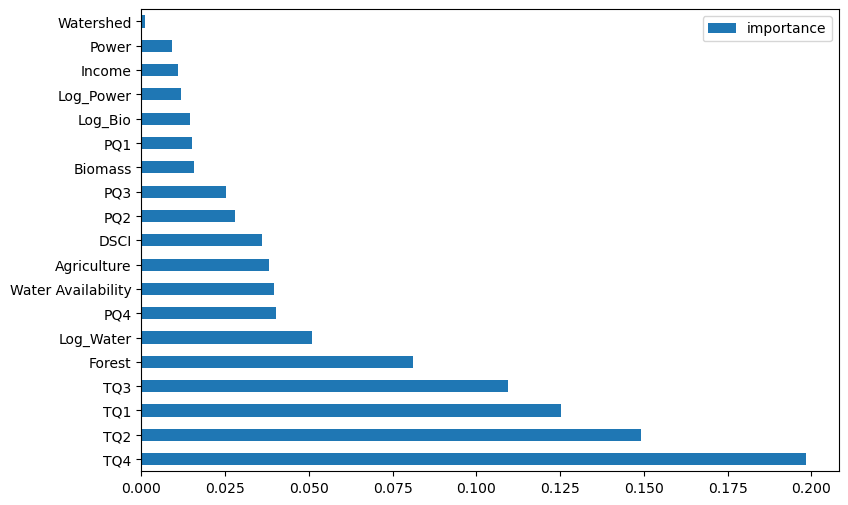

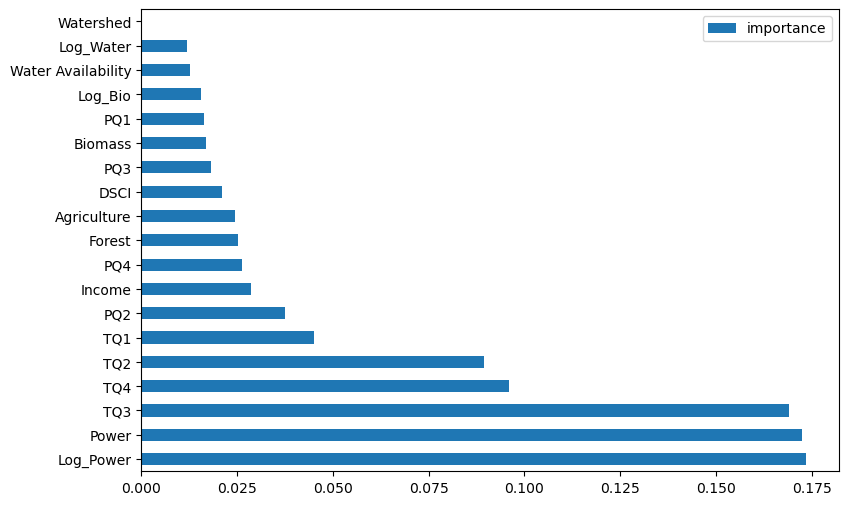

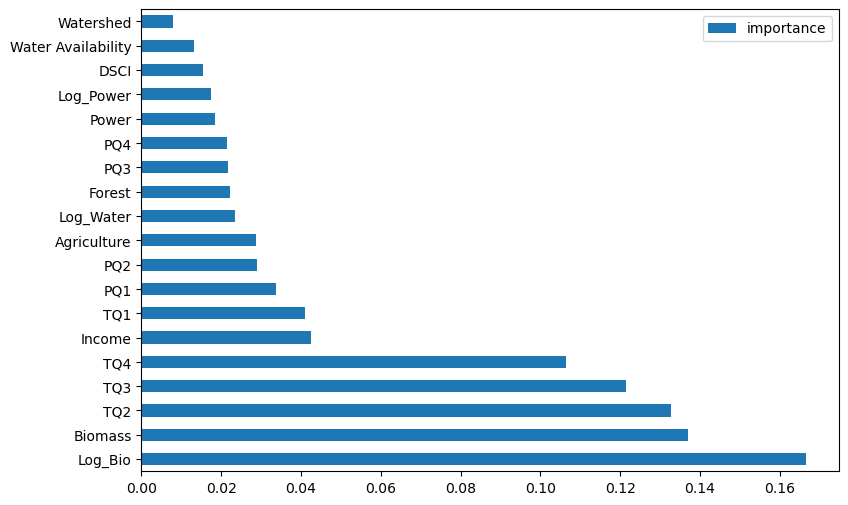

In [26]:
#Feature importance visualisation
feature_imp_rf.plot(kind='barh') #reforest
feature_imp_ew.plot(kind='barh') #ew
feature_imp_bio.plot(kind='barh') #biochar

# Logistic Regression

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [17]:
logreg_model_rf = LogisticRegression()
logreg_model_ew = LogisticRegression()
logreg_model_bio = LogisticRegression()

logreg_model_rf.fit(X_train, y_train_rf)
logreg_model_ew.fit(X_train, y_train_ew)
logreg_model_bio.fit(X_train, y_train_bio)

# predict
y_pred_rf = logreg_model_rf.predict(X_test)
y_pred_ew = logreg_model_ew.predict(X_test)
y_pred_bio = logreg_model_bio.predict(X_test)

NameError: name 'LogisticRegression' is not defined

In [29]:
# To get model performance Reforest
from sklearn.metrics import classification_report
cr1 = classification_report(y_test_rf, y_pred_rf)
cr2 = classification_report(y_test_ew, y_pred_ew)
cr3 = classification_report(y_test_bio, y_pred_bio)
print('Reforestation:\n' , cr1, '\n')
print('EW:\n' , cr2, '\n')
print('Biochar:\n' , cr3, '\n')

Reforestation:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      1.00      0.89         8
           2       1.00      0.50      0.67         4

    accuracy                           0.88        17
   macro avg       0.93      0.83      0.85        17
weighted avg       0.91      0.88      0.87        17
 

EW:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       1.00      0.57      0.73         7
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3

    accuracy                           0.82        17
   macro avg       0.91      0.89      0.87        17
weighted avg       0.89      0.82      0.82        17
 

Biochar:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      1.00      1

In [30]:
print("Reforestation Accuracy:", accuracy_score(y_test_rf, y_pred_rf), '\n')
print("EW Accuracy:", accuracy_score(y_test_ew, y_pred_ew), '\n')
print("Biochar Accuracy:", accuracy_score(y_test_bio, y_pred_bio), '\n')

Reforestation Accuracy: 0.8823529411764706 

EW Accuracy: 0.8235294117647058 

Biochar Accuracy: 0.8823529411764706 



In [31]:
feature_names = X_train.columns

coeffs_rf = pd.DataFrame({'Feature': feature_names, 'Coefficient': logreg_model_rf.coef_[0]})
coeffs_ew = pd.DataFrame({'Feature': feature_names, 'Coefficient': logreg_model_ew.coef_[0]})
coeffs_bio = pd.DataFrame({'Feature': feature_names, 'Coefficient': logreg_model_bio.coef_[0]})

coeffs_rf['Abs_Coefficient'] = abs(coeffs_rf['Coefficient'])
coeffs_ew['Abs_Coefficient'] = abs(coeffs_ew['Coefficient'])
coeffs_bio['Abs_Coefficient'] = abs(coeffs_bio['Coefficient'])

coeffs_rf.sort_values(by='Abs_Coefficient', ascending=False, inplace=True)
coeffs_ew.sort_values(by='Abs_Coefficient', ascending=False, inplace=True)
coeffs_bio.sort_values(by='Abs_Coefficient', ascending=False, inplace=True)

<Axes: ylabel='Feature'>

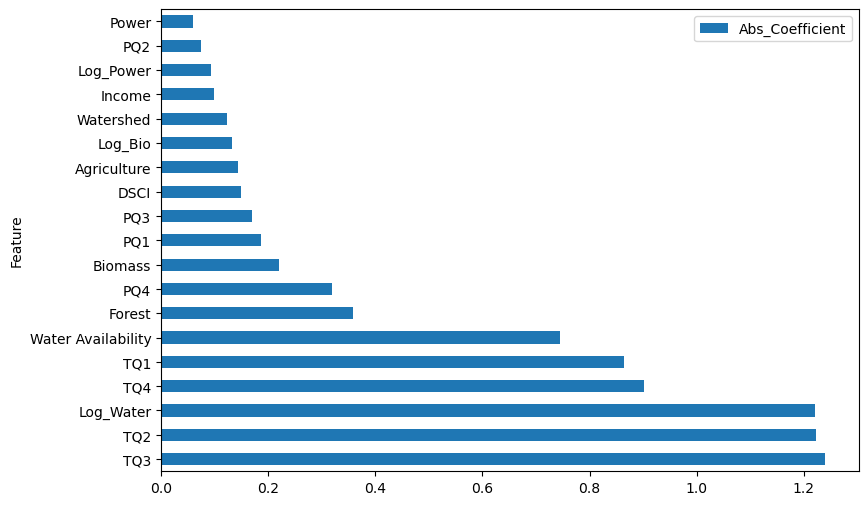

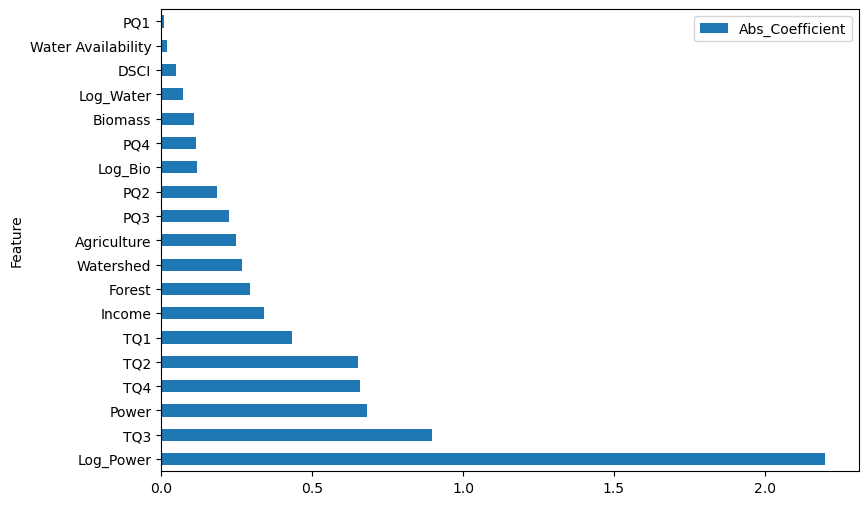

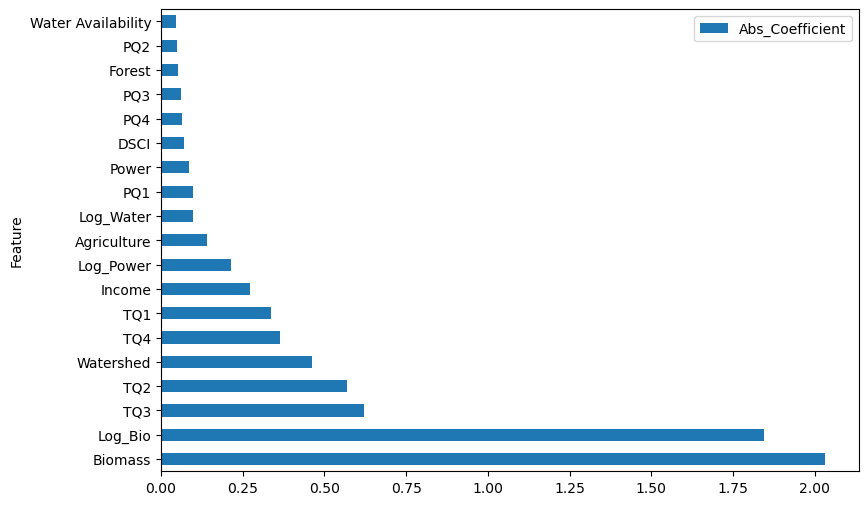

In [32]:
#Feature importance visualisation
coeffs_rf.plot(kind='barh', x='Feature', y='Abs_Coefficient')
coeffs_ew.plot(kind='barh', x='Feature', y='Abs_Coefficient')
coeffs_bio.plot(kind='barh', x='Feature', y='Abs_Coefficient')

# Descision Tree

In [20]:
# supervised learning method
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [19]:
dt_model_rf = DecisionTreeClassifier(random_state=0)
dt_model_ew = DecisionTreeClassifier(random_state=0)
dt_model_bio = DecisionTreeClassifier(random_state=0)

dt_model_rf.fit(X_train, y_train_rf)
dt_model_ew.fit(X_train, y_train_ew)
dt_model_bio.fit(X_train, y_train_bio)

y_pred_rf = dt_model_rf.predict(X_test)
y_pred_ew = dt_model_ew.predict(X_test)
y_pred_bio = dt_model_bio.predict(X_test)

print('Reforestation:\n',classification_report(y_test_rf, y_pred_rf),'\n')
print('EW:\n',classification_report(y_test_ew, y_pred_ew),'\n')
print('Biochar:\n',classification_report(y_test_bio, y_pred_bio),'\n')

Reforestation:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.89      1.00      0.94         8
           2       1.00      0.75      0.86         4

    accuracy                           0.94        17
   macro avg       0.96      0.92      0.93        17
weighted avg       0.95      0.94      0.94        17
 

EW:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17
 

Biochar:
               precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       1.00      1.00      1

[Text(0.6, 0.9166666666666666, 'x[9] <= 0.592\ngini = 0.692\nsamples = 67\nvalue = [19, 23, 22, 3]'),
 Text(0.5, 0.75, 'x[7] <= 0.544\ngini = 0.609\nsamples = 47\nvalue = [19, 3, 22, 3]'),
 Text(0.2, 0.5833333333333334, 'x[10] <= 0.307\ngini = 0.376\nsamples = 22\nvalue = [17, 0, 2, 3]'),
 Text(0.1, 0.4166666666666667, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 0, 3]'),
 Text(0.3, 0.4166666666666667, 'x[17] <= 0.521\ngini = 0.188\nsamples = 19\nvalue = [17, 0, 2, 0]'),
 Text(0.2, 0.25, 'x[11] <= 0.156\ngini = 0.5\nsamples = 4\nvalue = [2, 0, 2, 0]'),
 Text(0.1, 0.08333333333333333, 'gini = 0.0\nsamples = 2\nvalue = [2, 0, 0, 0]'),
 Text(0.3, 0.08333333333333333, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 2, 0]'),
 Text(0.4, 0.25, 'gini = 0.0\nsamples = 15\nvalue = [15, 0, 0, 0]'),
 Text(0.8, 0.5833333333333334, 'x[10] <= 0.503\ngini = 0.339\nsamples = 25\nvalue = [2, 3, 20, 0]'),
 Text(0.7, 0.4166666666666667, 'x[17] <= 0.721\ngini = 0.48\nsamples = 5\nvalue = [2, 3, 0, 0]'),
 Text(0.6, 0.

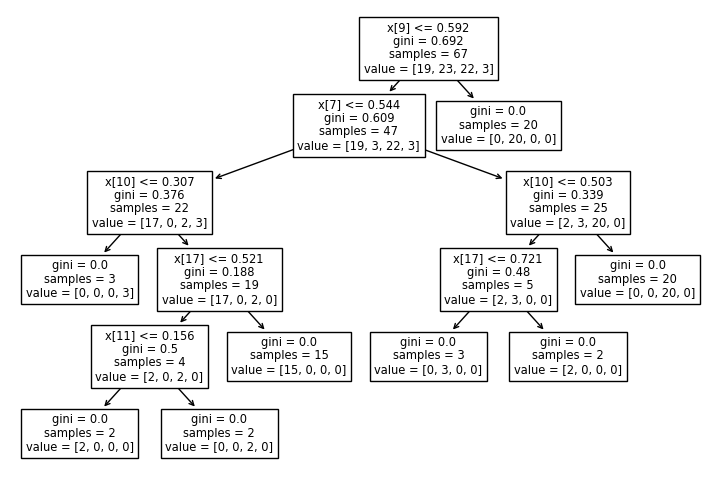

In [22]:
tree.plot_tree(dt_model_rf)

In [35]:
print("Reforestation Accuracy:", accuracy_score(y_test_rf, y_pred_rf), '\n')
print("EW Accuracy:", accuracy_score(y_test_ew, y_pred_ew), '\n')
print("Biochar Accuracy:", accuracy_score(y_test_bio, y_pred_bio), '\n')

Reforestation Accuracy: 0.9411764705882353 

EW Accuracy: 1.0 

Biochar Accuracy: 0.7647058823529411 



In [36]:
print('Reforestation:\n',cross_val_score(dt_model_rf, X_train, y_train_rf, cv=10),'\n')
print('EW:\n',cross_val_score(dt_model_ew, X_train, y_train_ew, cv=10),'\n')
print('Biochar:\n',cross_val_score(dt_model_bio, X_train, y_train_bio, cv=10),'\n')

Reforestation:
 [0.71428571 0.57142857 1.         0.71428571 0.71428571 0.85714286
 1.         0.66666667 0.83333333 1.        ] 

EW:
 [1.         1.         1.         1.         1.         1.
 1.         1.         0.83333333 1.        ] 



C:\Users\daven\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\daven\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Biochar:
 [0.85714286 0.71428571 0.85714286 0.85714286 0.42857143 0.71428571
 0.57142857 0.66666667 1.         0.83333333] 



# KNN

In [37]:
from sklearn.neighbors import KNeighborsClassifier
n_acc_rf = [0]*11
n_acc_ew = [0]*11
n_acc_bio = [0]*11

print('Reforestation:')
for n in [1,2,3,4,5,6,7,8,9,10]:
    neigh_rf = KNeighborsClassifier(n_neighbors=n)
    
    neigh_rf.fit(X_train, y_train_rf)
    
    preds_rf = neigh_rf.predict(X_test)
    
    correct_rf = 0
    
    for i in range(len(preds_rf)):
        if preds_rf[i]==y_test_rf.values[i]:
            correct_rf += 1
    acc_rf = correct_rf/len(preds_rf)
    n_acc_rf[n] = acc_rf
    print(f'{n} neighbors - validation accuracy: {round(acc_rf, 5)} {correct_rf}/{len(preds_rf)}')
    
print('\nEW:')   
for n in [1,2,3,4,5,6,7,8,9,10]:
    neigh_ew = KNeighborsClassifier(n_neighbors=n)
    
    neigh_ew.fit(X_train, y_train_ew)
    
    preds_ew = neigh_ew.predict(X_test)
    
    correct_ew = 0
    
    for i in range(len(preds_ew)):
        if preds_ew[i]==y_test_ew.values[i]:
            correct_ew += 1
    acc_ew = correct_ew/len(preds_ew)
    n_acc_ew[n] = acc_ew
    print(f'{n} neighbors - validation accuracy: {round(acc_ew, 5)} {correct_ew}/{len(preds_ew)}')

print('\nBiochar:')
for n in [1,2,3,4,5,6,7,8,9,10]:
    neigh_bio = KNeighborsClassifier(n_neighbors=n)
    
    neigh_bio.fit(X_train, y_train_bio)
    
    preds_bio = neigh_bio.predict(X_test)
    
    correct_bio = 0
    
    for i in range(len(preds_bio)):
        if preds_bio[i]==y_test_bio.values[i]:
            correct_bio += 1
    acc_bio = correct_bio/len(preds_bio)
    n_acc_bio[n] = acc_bio
    print(f'{n} neighbors - validation accuracy: {round(acc_bio, 5)} {correct_bio}/{len(preds_bio)}')

Reforestation:
1 neighbors - validation accuracy: 0.82353 14/17
2 neighbors - validation accuracy: 0.64706 11/17
3 neighbors - validation accuracy: 0.82353 14/17
4 neighbors - validation accuracy: 0.76471 13/17
5 neighbors - validation accuracy: 0.82353 14/17


C:\Users\daven\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\daven\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\daven\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\daven\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

6 neighbors - validation accuracy: 0.82353 14/17
7 neighbors - validation accuracy: 0.82353 14/17
8 neighbors - validation accuracy: 0.70588 12/17
9 neighbors - validation accuracy: 0.70588 12/17
10 neighbors - validation accuracy: 0.76471 13/17

EW:
1 neighbors - validation accuracy: 0.94118 16/17
2 neighbors - validation accuracy: 0.82353 14/17


C:\Users\daven\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\daven\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\daven\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\daven\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

3 neighbors - validation accuracy: 0.82353 14/17
4 neighbors - validation accuracy: 0.82353 14/17
5 neighbors - validation accuracy: 0.82353 14/17
6 neighbors - validation accuracy: 0.70588 12/17
7 neighbors - validation accuracy: 0.82353 14/17
8 neighbors - validation accuracy: 0.82353 14/17
9 neighbors - validation accuracy: 0.82353 14/17


C:\Users\daven\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\daven\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\daven\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\daven\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

10 neighbors - validation accuracy: 0.82353 14/17

Biochar:
1 neighbors - validation accuracy: 0.88235 15/17
2 neighbors - validation accuracy: 0.88235 15/17
3 neighbors - validation accuracy: 0.88235 15/17
4 neighbors - validation accuracy: 0.76471 13/17
5 neighbors - validation accuracy: 0.82353 14/17
6 neighbors - validation accuracy: 0.76471 13/17
7 neighbors - validation accuracy: 0.76471 13/17
8 neighbors - validation accuracy: 0.70588 12/17
9 neighbors - validation accuracy: 0.64706 11/17


C:\Users\daven\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\daven\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\daven\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\daven\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

10 neighbors - validation accuracy: 0.64706 11/17


Text(0.5, 1.0, 'Biochar Validation Accuracy By Number of Neighbors')

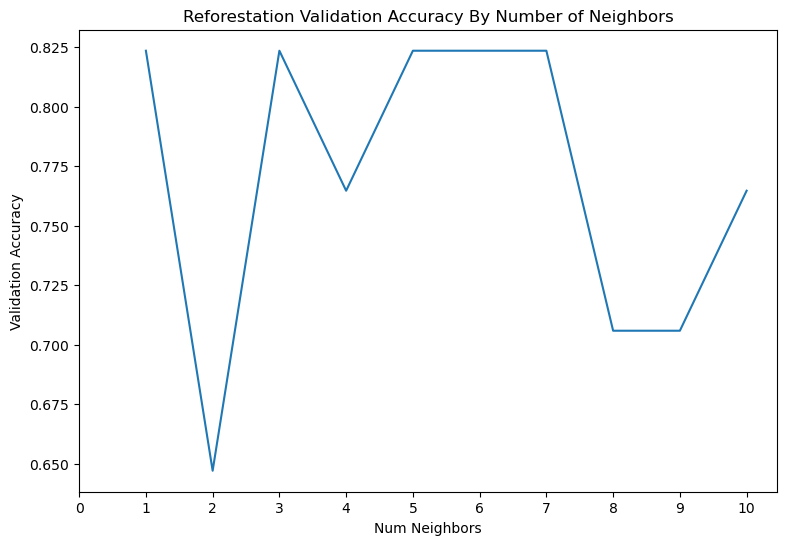

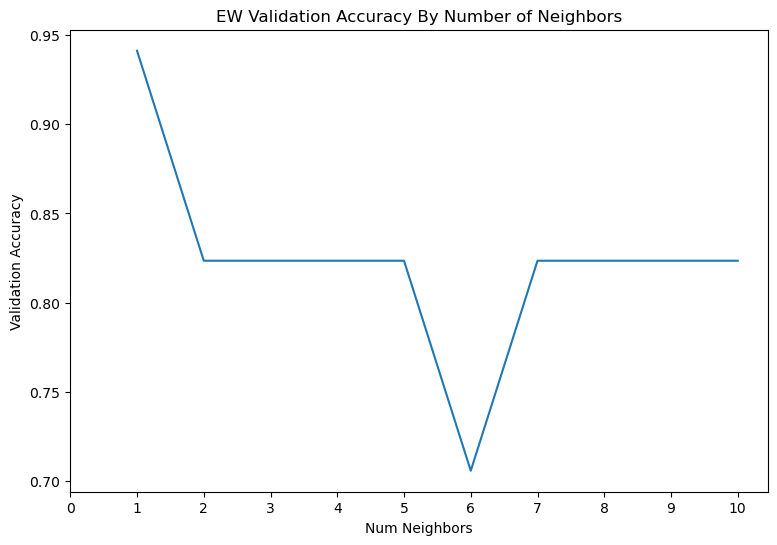

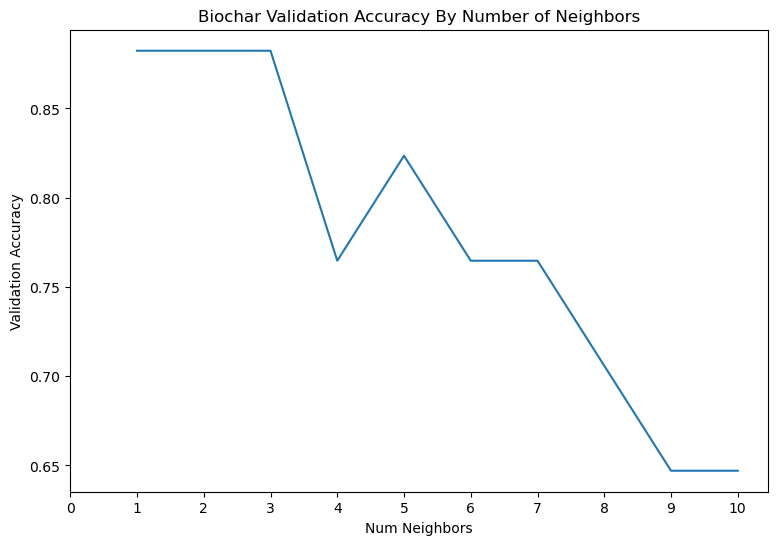

In [38]:
fig, ax = plt.subplots() 
ax.plot([i for i in range(1,len(n_acc_rf))], n_acc_rf[1:])
plt.xlabel('Num Neighbors')
plt.ylabel('Validation Accuracy')
ax.set_xticks(np.arange(len(n_acc_rf)))
plt.title('Reforestation Validation Accuracy By Number of Neighbors')

fig, ax = plt.subplots() 
ax.plot([i for i in range(1,len(n_acc_ew))], n_acc_ew[1:])
plt.xlabel('Num Neighbors')
plt.ylabel('Validation Accuracy')
ax.set_xticks(np.arange(len(n_acc_ew)))
plt.title('EW Validation Accuracy By Number of Neighbors')

fig, ax = plt.subplots() 
ax.plot([i for i in range(1,len(n_acc_bio))], n_acc_bio[1:])
plt.xlabel('Num Neighbors')
plt.ylabel('Validation Accuracy')
ax.set_xticks(np.arange(len(n_acc_bio)))
plt.title('Biochar Validation Accuracy By Number of Neighbors')

In [39]:
neigh_rf = KNeighborsClassifier(n_neighbors=3)
neigh_ew = KNeighborsClassifier(n_neighbors=1)
neigh_bio = KNeighborsClassifier(n_neighbors=3)

neigh_rf.fit(X_train, y_train_rf)
neigh_ew.fit(X_train, y_train_ew)
neigh_bio.fit(X_train, y_train_bio)

y_pred_rf = neigh_rf.predict(X_test)
y_pred_ew = neigh_ew.predict(X_test)
y_pred_bio = neigh_bio.predict(X_test)

print('Reforestation:\n',classification_report(y_test_rf, y_pred_rf),'\n')
print('EW:\n',classification_report(y_test_ew, y_pred_ew),'\n')
print('Biochar:\n',classification_report(y_test_bio, y_pred_bio),'\n')

Reforestation:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.80      1.00      0.89         8
           2       0.67      0.50      0.57         4

    accuracy                           0.82        17
   macro avg       0.82      0.77      0.78        17
weighted avg       0.83      0.82      0.81        17
 

EW:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       0.67      1.00      0.80         2
           3       1.00      0.67      0.80         3

    accuracy                           0.94        17
   macro avg       0.92      0.92      0.90        17
weighted avg       0.96      0.94      0.94        17
 

Biochar:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.71      1.00      0

C:\Users\daven\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\daven\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\daven\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [40]:
print("Reforestation Accuracy:", accuracy_score(y_test_rf, y_pred_rf), '\n')
print("EW Accuracy:", accuracy_score(y_test_ew, y_pred_ew), '\n')
print("Biochar Accuracy:", accuracy_score(y_test_bio, y_pred_bio), '\n')

Reforestation Accuracy: 0.8235294117647058 

EW Accuracy: 0.9411764705882353 

Biochar Accuracy: 0.8823529411764706 



# Naive Bayes

In [41]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes_model_rf = MultinomialNB()
naive_bayes_model_ew = MultinomialNB()
naive_bayes_model_bio = MultinomialNB()

naive_bayes_model_rf.fit(X_train, y_train_rf)
naive_bayes_model_ew.fit(X_train, y_train_ew)
naive_bayes_model_bio.fit(X_train, y_train_bio)

y_pred_rf = naive_bayes_model_rf.predict(X_test)
y_pred_ew = naive_bayes_model_ew.predict(X_test)
y_pred_bio = naive_bayes_model_bio.predict(X_test)

print('Reforestation:\n',classification_report(y_test_rf, y_pred_rf),'\n')
print('EW:\n',classification_report(y_test_ew, y_pred_ew),'\n')
print('Biochar:\n',classification_report(y_test_bio, y_pred_bio),'\n')

C:\Users\daven\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\daven\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\daven\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Reforestation:
               precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.64      0.88      0.74         8
           2       0.50      0.50      0.50         4

    accuracy                           0.65        17
   macro avg       0.71      0.59      0.60        17
weighted avg       0.71      0.65      0.63        17
 

EW:
               precision    recall  f1-score   support

           0       0.45      1.00      0.62         5
           1       1.00      0.14      0.25         7
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3

    accuracy                           0.65        17
   macro avg       0.86      0.79      0.72        17
weighted avg       0.84      0.65      0.58        17
 

Biochar:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.33      1.00      0

C:\Users\daven\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\daven\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\daven\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
print("Reforestation Accuracy:", accuracy_score(y_test_rf, y_pred_rf), '\n')
print("EW Accuracy:", accuracy_score(y_test_ew, y_pred_ew), '\n')
print("Biochar Accuracy:", accuracy_score(y_test_bio, y_pred_bio), '\n')

Reforestation Accuracy: 0.6470588235294118 

EW Accuracy: 0.6470588235294118 

Biochar Accuracy: 0.35294117647058826 



# Gradient Boost

In [43]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

#fit gradient boosted stumps (trees w depth=1)
clf_rf = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=1.0, 
                                 max_depth=1, 
                                 random_state=0).fit(X_train, y_train_rf)
clf_ew = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=1.0, 
                                 max_depth=1, 
                                 random_state=0).fit(X_train, y_train_ew)
clf_bio = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=1.0, 
                                 max_depth=1, 
                                 random_state=0).fit(X_train, y_train_bio)

C:\Users\daven\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\daven\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\daven\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [44]:
y_pred_rf = clf_rf.predict(X_test)
y_pred_ew = clf_ew.predict(X_test)
y_pred_bio = clf_bio.predict(X_test)

print('Reforestation:\n',classification_report(y_test_rf, y_pred_rf),'\n')
print('EW:\n',classification_report(y_test_ew, y_pred_ew),'\n')
print('Biochar:\n',classification_report(y_test_bio, y_pred_bio),'\n')

Reforestation:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      1.00      0.89         8
           2       1.00      0.50      0.67         4

    accuracy                           0.88        17
   macro avg       0.93      0.83      0.85        17
weighted avg       0.91      0.88      0.87        17
 

EW:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       0.67      1.00      0.80         2
           3       1.00      0.67      0.80         3

    accuracy                           0.94        17
   macro avg       0.92      0.92      0.90        17
weighted avg       0.96      0.94      0.94        17
 

Biochar:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1

In [45]:
print("Reforestation Accuracy:", accuracy_score(y_test_rf, y_pred_rf), '\n')
print("EW Accuracy:", accuracy_score(y_test_ew, y_pred_ew), '\n')
print("Biochar Accuracy:", accuracy_score(y_test_bio, y_pred_bio), '\n')

Reforestation Accuracy: 0.8823529411764706 

EW Accuracy: 0.9411764705882353 

Biochar Accuracy: 1.0 



In [46]:
feature_imp_rf = pd.DataFrame(clf_rf.feature_importances_,index= X_train.columns, columns=['importance']).sort_values('importance',ascending=False)
feature_imp_ew = pd.DataFrame(clf_ew.feature_importances_,index= X_train.columns, columns=['importance']).sort_values('importance',ascending=False)
feature_imp_bio = pd.DataFrame(clf_bio.feature_importances_,index= X_train.columns, columns=['importance']).sort_values('importance',ascending=False)


print('Reforestation:\n' , feature_imp_rf , "\n")
print('Enhanced Weathering:\n' , feature_imp_ew , "\n")
print('Biochar:\n' , feature_imp_bio , "\n")

Reforestation:
                       importance
TQ4                 4.632203e-01
TQ2                 2.645894e-01
Forest              1.324211e-01
Log_Water           3.932503e-02
DSCI                2.932859e-02
PQ2                 2.869351e-02
TQ1                 2.537372e-02
TQ3                 9.208790e-03
Income              3.799238e-03
Power               2.028608e-03
Water Availability  1.093209e-03
PQ1                 8.006171e-04
Agriculture         1.167350e-04
PQ3                 5.476028e-07
Log_Power           3.716954e-07
PQ4                 2.375560e-07
Biomass             1.090135e-16
Watershed           0.000000e+00
Log_Bio             0.000000e+00 

Enhanced Weathering:
                       importance
TQ3                 4.213796e-01
Log_Power           3.157270e-01
Power               1.370100e-01
TQ2                 8.985048e-02
Agriculture         3.011006e-02
TQ4                 3.950762e-03
PQ1                 8.711781e-04
Income              4.375700e-04
DSC

<Axes: >

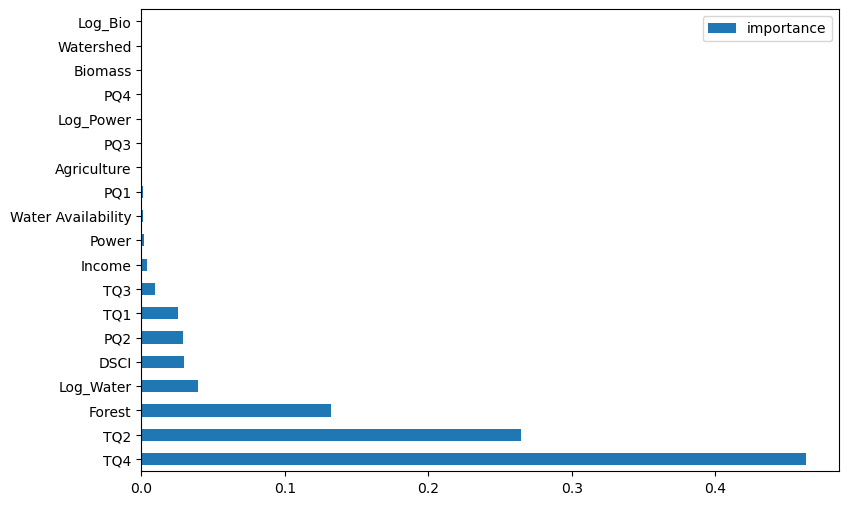

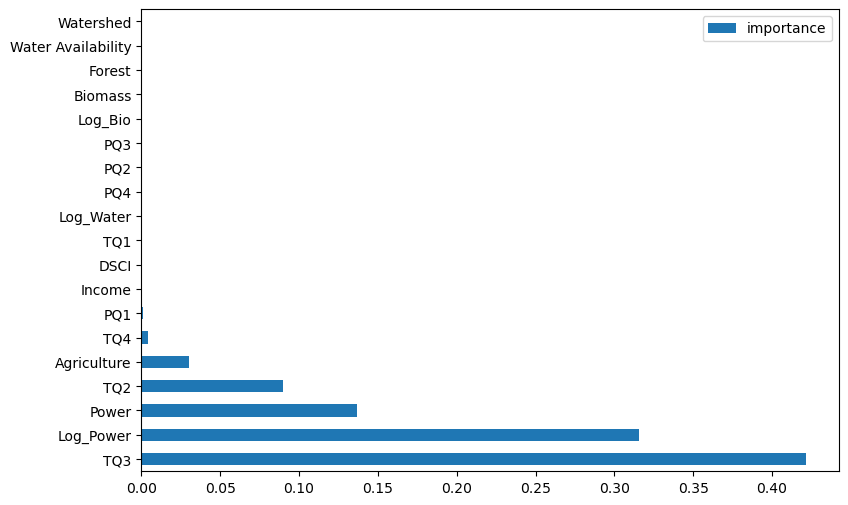

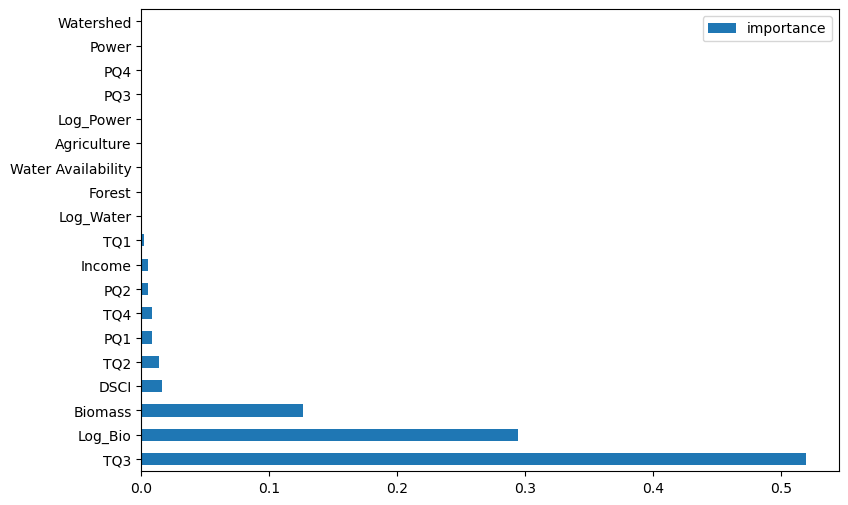

In [47]:
#Feature importance visualisation
feature_imp_rf.plot(kind='barh') #reforest
feature_imp_ew.plot(kind='barh') #ew
feature_imp_bio.plot(kind='barh') #biochar

# Neural Net

## Feed Forward ANN (MLPClassifier from sklearn)

In [48]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

clf_rf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train_rf)
clf_ew = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train_ew)
clf_bio = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train_bio)

C:\Users\daven\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1096: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\daven\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\daven\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1096: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\daven\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization h

In [49]:
clf_rf.predict_proba(X_test)

array([[2.95897929e-03, 9.29960226e-01, 6.64798397e-02, 6.00954577e-04],
       [6.70060916e-02, 7.93123671e-01, 1.20654036e-01, 1.92162011e-02],
       [8.41205549e-02, 5.61687655e-01, 3.45744517e-01, 8.44727241e-03],
       [8.85369197e-01, 1.11985861e-02, 9.82126094e-02, 5.21960780e-03],
       [6.26315438e-04, 9.50534782e-01, 3.94956000e-02, 9.34330267e-03],
       [6.82987567e-02, 6.60701488e-01, 2.55159142e-01, 1.58406132e-02],
       [9.99935113e-01, 6.88636972e-08, 3.91346412e-05, 2.56837741e-05],
       [9.10603378e-01, 1.23853308e-03, 8.15848589e-02, 6.57322992e-03],
       [7.31161996e-01, 1.07414845e-02, 2.43009981e-01, 1.50865394e-02],
       [6.36255542e-03, 8.01221777e-01, 1.82804961e-01, 9.61070674e-03],
       [1.27925041e-02, 7.34509050e-02, 9.12249426e-01, 1.50716494e-03],
       [1.63453804e-02, 7.55388276e-01, 2.08164770e-01, 2.01015737e-02],
       [2.60798358e-02, 5.25121202e-01, 4.45402556e-01, 3.39640657e-03],
       [3.74755283e-02, 7.60566311e-01, 1.94820405e

In [50]:
y_pred_rf = clf_rf.predict(X_test)
y_pred_ew = clf_ew.predict(X_test)
y_pred_bio = clf_bio.predict(X_test)
y_pred_rf

array([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 2, 1, 1, 1, 2, 1, 0], dtype=int64)

In [52]:
print('Reforestation:\n',classification_report(y_test_rf, y_pred_rf),'\n')
print('EW:\n',classification_report(y_test_ew, y_pred_ew),'\n')
print('Biochar:\n',classification_report(y_test_bio, y_pred_bio),'\n')

Reforestation:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      1.00      0.89         8
           2       1.00      0.50      0.67         4

    accuracy                           0.88        17
   macro avg       0.93      0.83      0.85        17
weighted avg       0.91      0.88      0.87        17
 

EW:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17
 

Biochar:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1

In [53]:
print("Reforestation Accuracy:", accuracy_score(y_test_rf, y_pred_rf), '\n')
print("EW Accuracy:", accuracy_score(y_test_ew, y_pred_ew), '\n')
print("Biochar Accuracy:", accuracy_score(y_test_bio, y_pred_bio), '\n')

Reforestation Accuracy: 0.8823529411764706 

EW Accuracy: 1.0 

Biochar Accuracy: 1.0 



## Simple ANN

In [54]:
# loading everything that might be helpful
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import torch
from torch.utils.data import DataLoader, random_split
from torch import Generator
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch import manual_seed as torch_manual_seed
import random
import numpy as np

from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

In [55]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [94]:
# Make data into tensor objects
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

y_train_rf_tensor = torch.tensor(y_train_rf['Reforest'].values, dtype=torch.float32)
y_train_ew_tensor = torch.tensor(y_train_ew['EW'].values, dtype=torch.float32)
y_train_bio_tensor = torch.tensor(y_train_bio['Biochar'].values, dtype=torch.float32)

y_test_rf_tensor = torch.tensor(y_test_rf['Reforest'].values, dtype=torch.float32)
y_test_ew_tensor = torch.tensor(y_test_ew['EW'].values, dtype=torch.float32)
y_test_bio_tensor = torch.tensor(y_test_bio['Biochar'].values, dtype=torch.float32)

# Make test data into tensor objects
X_val_tensor = torch.tensor(dataset_val.values, dtype=torch.float32)

In [95]:
#train data
training_data_rf = TensorDataset(X_train_tensor, y_train_rf_tensor)
train_dataloader_rf = DataLoader(training_data_rf, batch_size=16)

training_data_ew = TensorDataset(X_train_tensor, y_train_ew_tensor)
train_dataloader_ew = DataLoader(training_data_ew, batch_size=16)

training_data_bio = TensorDataset(X_train_tensor, y_train_bio_tensor)
train_dataloader_bio = DataLoader(training_data_bio, batch_size=16)


#test data
test_data_rf = TensorDataset(X_test_tensor,  y_test_rf_tensor)
test_dataloader_rf = DataLoader(test_data_rf, batch_size=16)

test_data_ew = TensorDataset(X_test_tensor,  y_test_ew_tensor)
test_dataloader_ew = DataLoader(test_data_ew, batch_size=16)

test_data_bio = TensorDataset(X_test_tensor,  y_test_bio_tensor)
test_dataloader_bio = DataLoader(test_data_bio, batch_size=16)


#validate data
val_data = TensorDataset(X_val_tensor)
val_dataloader = DataLoader(val_data, batch_size=16)

In [59]:
# Simple ANN

In [66]:
import torch.nn as nn

#define model
class net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_model = nn.Sequential(
            nn.Linear(19,100), #19 input columns
            nn.Tanh(),
            nn.Linear(100,4) #4 output classes

    )

    def forward(self, x):
        logits = self.linear_model(x)
        return logits

model_rf = net()
model_ew = net()
model_bio = net()
model_rf

net(
  (linear_model): Sequential(
    (0): Linear(in_features=19, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=4, bias=True)
  )
)

In [67]:
learning_rate = 0.005
batch_size = 16
epochs = 25
loss_fn = nn.CrossEntropyLoss()
optimizer_rf = torch.optim.SGD(model_rf.parameters(), lr=learning_rate)
optimizer_ew = torch.optim.SGD(model_ew.parameters(), lr=learning_rate)
optimizer_bio = torch.optim.SGD(model_bio.parameters(), lr=learning_rate)

In [99]:
#train loop
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train() #set model in train mode
    size = len(dataloader.dataset)

    for batch, (X,y) in enumerate(dataloader):
        #prediction and loss
        #y = y.unsqueeze(1)
        y = y.long()
        pred = model(X)
        loss = loss_fn(pred, y)

        #backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if batch % 10 == 0:
        loss, current = loss.item(), batch * batch_size + len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [70]:
def test_loop(train_dataloader, test_dataloader, model, loss_fn):
    model.eval()  # set model in evaluation mode

    size_train = len(train_dataloader.dataset)
    size_test = len(test_dataloader.dataset)

    num_batches_train = len(train_dataloader)
    num_batches_test = len(test_dataloader)

    train_loss, correct_train = 0, 0
    test_loss, correct_test = 0, 0

    # Evaluate model on train data
    with torch.no_grad():
        for X, y in train_dataloader:
            #y = y.unsqueeze(1)
            y = y.long()
            pred = model(X)
            train_loss += loss_fn(pred, y).item()
            correct_train += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= num_batches_train
    correct_train /= size_train
    print(f"Train Error: \n Accuracy: {(100*correct_train):>0.1f}%, Avg loss: {train_loss:>8f}")

    # Evaluate model on validation data
    with torch.no_grad():
        for X, y in test_dataloader:
            #y = y.unsqueeze(1)
            y = y.long()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct_test += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches_test
    correct_test /= size_test
    print(f"Validation Error: \n Accuracy: {(100*correct_test):>0.1f}%, Avg loss: {test_loss:>8f}")


In [102]:
#run the code for rf
#epochs = 1000
#for t in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    #train_loop(train_dataloader_rf, model_rf, loss_fn, optimizer_rf)
    #test_loop(train_dataloader_rf, test_dataloader_rf, model_rf, loss_fn)
#print("Done!")

In [101]:
#-------------------------------
#Train Error: 
 #Accuracy: 97.0%, Avg loss: 0.221216
#Validation Error: 
 #Accuracy: 88.2%, Avg loss: 0.261218
#Epoch 1000

In [107]:
#run the code for ew
#epochs = 1000
#for t in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    #train_loop(train_dataloader_ew, model_ew, loss_fn, optimizer_ew)
    #test_loop(train_dataloader_ew, test_dataloader_ew, model_ew, loss_fn)
#print("Done!")

In [106]:
#-------------------------------
#Train Error: 
 #Accuracy: 100.0%, Avg loss: 0.114820
#Validation Error: 
 #Accuracy: 94.1%, Avg loss: 0.112294
#Epoch 1000

In [110]:
#run the code for bio
#epochs = 1000
#for t in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    #train_loop(train_dataloader_bio, model_bio, loss_fn, optimizer_bio)
    #test_loop(train_dataloader_bio, test_dataloader_bio, model_bio, loss_fn)
#print("Done!")

In [109]:
#---------------------------
#Train Error: 
 #Accuracy: 95.5%, Avg loss: 0.248146
#Validation Error: 
 #Accuracy: 100.0%, Avg loss: 0.125526
#Epoch 1000